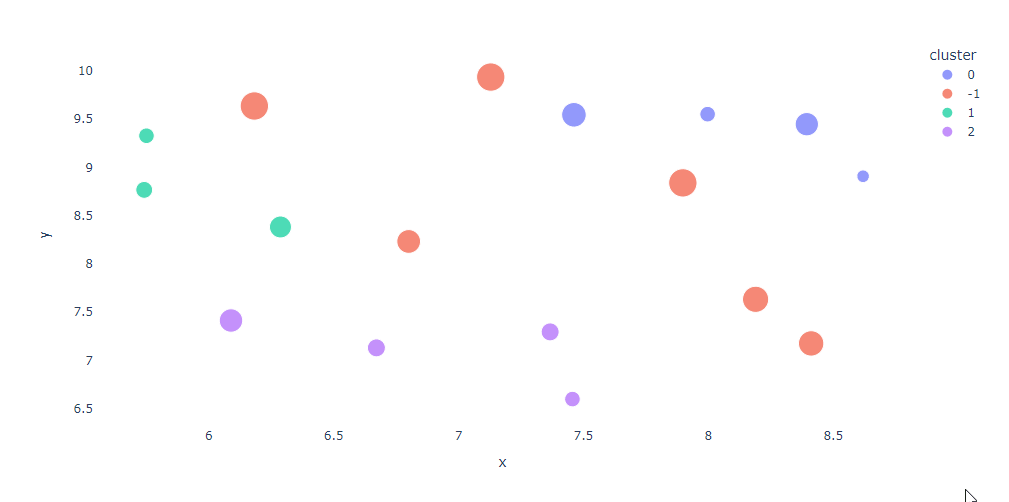

# Feedback Triage
Use light NLP to group and categorize feedback on a class

In [136]:
# imports
import hdbscan
import pandas as pd
from textblob import TextBlob
import umap.umap_ as umap
import plotly.express as px
from sentence_transformers import SentenceTransformer

"""
This call below will require an active internet connection; 
you can also pass the folder of a downloaded model if you need to run it offline
"""
model = SentenceTransformer("all-MiniLM-L6-v2")

In [131]:
# You can also just create a dataframe from a CSV or excel doc
reviews = ["This instructor is the best", 
           "I learned so much!", 
           'Great class', 
           'This class was terrible, I hope everyone dies in a fire', 
           "0/5 stars",
          "We really missed out on the aardvark content. I could have done with more aardvarks and anteaters",
          "I'm partial to anteaters as well",
           "Aardvarks are my favorite",
          "I wish we could have drank during the class, sobriety ruined the experience",
          'Excellent slides, terrible mustache',
          'Lunch was too short',
          "I didn't like it",
          'The instruction could have been longer',
          "Why didn't anyone tell me the coffee in the break room was free?",
          "It's a great experience to go to a class from a different branch",
          "The free coffee was fantastic",
          "Could have used longer lunches",
          "Lunch was too long",
          "I didn't like the small group portion",
          "I super hated everything here"]

In [132]:
df = pd.DataFrame(reviews).rename(columns={0:'Review'})
df['Sentiment'] = df['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['Subjectivity'] = df['Review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [133]:
## Make embeddings out of the text
sentence_embeddings = model.encode(reviews)
"""
By default, these embeddings are something like 350-1500 dimensions long. 
Clustering algos like <50 dimensions, and viz prefers 2-3. So pick a number between
2 and 50 for your dimensionality reduction.
Defaults to 2, consider bumping this up to 5 or 10 if you don't like the results you're seeing
"""

reducer = umap.UMAP(n_components=2)
embedding = reducer.fit_transform(sentence_embeddings)

In [134]:
df['x'] = [x[0] for x in embedding]
df['y'] = [x[1] for x in embedding]

## Explore the data in terms of Sentiment

In [135]:
fig = px.scatter(df, x='x', y='y', color='Sentiment', size='Subjectivity', hover_data=['Subjectivity', 'Sentiment', 'Review'],
          color_continuous_scale='viridis')

fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})

## Cluster the data

In [138]:
'''
This is where you can make or break the quality of your clusters. For larger corpora, I'd bump the min_cluster_size. 

You can also set this to return a confidence score... And if you really want to get wild, you can also do
"soft clustering", aka documents are allowed to belong to more than one group.
'''
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, gen_min_span_tree=True)
"""
This is making a deliberate choice to use the dimensionality-reduced sentence embeddings weighted equally with the
Sentiment and Subjectivity scores. You could tip the cluster weight in favor of content by reducing the dimensionality of the
input sentence embeddings to 4-20 dimensions instead. Two dimensions is handy for viz though!

Definitely reduce to 50 or fewer dimensions; clustering doesn't like highly dimensional data.
"""
clusterer.fit(df[['Sentiment', 'Subjectivity', 'x', 'y']].values.tolist())
df['cluster'] = clusterer.labels_

HDBSCAN(gen_min_span_tree=True, min_cluster_size=3)

## Explore the clustered data

In [144]:
df['cluster']=df['cluster'].astype(str)

fig = px.scatter(df, x='x', y='y', color='cluster', size='Subjectivity', hover_data=['Subjectivity', 'Sentiment', 'Review'])
# ,color_continuous_scale='viridis')

fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})